In [1]:
#%matplotlib notebook
#%matplotlib qt
%matplotlib inline

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('ticks')

from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


# Initial dataset

In [2]:
dataset_df = pd.read_csv('./datasets/OUTPUT_WBI_exposer_cyclones_v2.csv',sep=",")
print('size of the whole dataset: {}'.format(len(dataset_df)))
print('columns:',list(dataset_df.columns))

size of the whole dataset: 1005
columns: ['Unnamed: 0', 'SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE', 'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP', '96KN_ASSETS', 'CPI', 'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 'Cereal yield (kg per hectare)', 'Food production index (2004-2006 = 100)', 'GDP growth (annual %)', 'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$', 'Life expectancy at birth, total (years)', 'Mobile cellular subscriptions (per 100 people)', 'Population density (people per sq. km of land area)', 'Adjusted savings: education expenditure (% of GNI)', 'Rural population (% of total population)', 'Income_level_Final', 'TOTAL_AFFECTED', 'Population, total', 'Population_2000', 'Population_2005', 'P

# First filter
Here I made a selection of the columns I think contain the most important information

In [3]:
df1_columns = ['YEAR',
               'TOTAL_HRS',
               'USA_SSHS',
               'V_LAND_KN',
               'pop_max_34_adj',
               'pop_max_50_adj',
               'pop_max_64_adj',                    
               'GDP per capita (constant 2010 US$)',
               'GDP growth (annual %)',
               'Net flows from UN agencies US$',
               'Income_level_Final',                         
               'Air transport, freight (million ton-km)',
               'Arable land (hectares per person)',
               'Cereal yield (kg per hectare)',
               'Food production index (2004-2006 = 100)',
               'Life expectancy at birth, total (years)',                   
               'CPI',
               'TOTAL_DAMAGE_(000$)',
               'TOTAL_DEATHS',
               'TOTAL_AFFECTED']
df1 = dataset_df[df1_columns]

#Year cutoff
df1 = df1[df1['YEAR']>=1970]
df1.sort_values(by=['YEAR'],inplace=True) #display the df in ascending order of 'YEAR'
df1.reset_index(drop=True,inplace=True)

#Convertion from -5 to NaN i USA_SSHS (Xavier's observations)
df1['USA_SSHS']=df1['USA_SSHS'].replace(-5,np.nan)

df1['Income_level_Final']=df1['Income_level_Final'].replace('Low',1)
df1['Income_level_Final']=df1['Income_level_Final'].replace('Low_Middle',2)
df1['Income_level_Final']=df1['Income_level_Final'].replace('High_Middle',3)
df1['Income_level_Final']=df1['Income_level_Final'].replace('High',4)
df1['TOTAL_DAMAGE_(000$)_adj']= df1['TOTAL_DAMAGE_(000$)']/df1['CPI']
df1['TOTAL_DAMAGE_(000$)_adj']= df1['TOTAL_DAMAGE_(000$)_adj'].replace(0, np.nan)

#Since these quantities span a large range of values, we will use ln(pop_max). 
df1['pop_max_34_adj']=df1['pop_max_34_adj'].replace(0,np.nan)
df1['pop_max_50_adj']=df1['pop_max_50_adj'].replace(0,np.nan)
df1['pop_max_64_adj']=df1['pop_max_64_adj'].replace(0,np.nan)
df1['Air transport, freight (million ton-km)']=df1['Air transport, freight (million ton-km)'].replace(0,np.nan)
#Here we get rid of 'Net flows' < 0 (only two records which look very suspicious)
df1 = df1[df1['Net flows from UN agencies US$']>=0]
df1['Net flows from UN agencies US$']=df1['Net flows from UN agencies US$'].replace(0,np.nan)

#account of NaNs for each column
df1.isna().sum()

YEAR                                         0
TOTAL_HRS                                    0
USA_SSHS                                     7
V_LAND_KN                                    0
pop_max_34_adj                              98
pop_max_50_adj                             127
pop_max_64_adj                             196
GDP per capita (constant 2010 US$)           9
GDP growth (annual %)                       23
Net flows from UN agencies US$             181
Income_level_Final                           0
Air transport, freight (million ton-km)    118
Arable land (hectares per person)            1
Cereal yield (kg per hectare)                9
Food production index (2004-2006 = 100)      4
Life expectancy at birth, total (years)      4
CPI                                          0
TOTAL_DAMAGE_(000$)                        293
TOTAL_DEATHS                               129
TOTAL_AFFECTED                               0
TOTAL_DAMAGE_(000$)_adj                    293
dtype: int64

# Logarithmic transformation
This very useful to fight skewness and give the same importance to all features

In [4]:
ln_columns = ['pop_max_34_adj',
              'pop_max_50_adj',
              'pop_max_64_adj',
              'GDP per capita (constant 2010 US$)',
              'Net flows from UN agencies US$',
              'Air transport, freight (million ton-km)',
              'TOTAL_DAMAGE_(000$)_adj',
              'TOTAL_DEATHS',
              'TOTAL_AFFECTED']
for name in ln_columns:
    df1['ln('+name+')'] = df1.apply(lambda x: np.log(x[name]),axis=1)

# Second filter
Here I select the final set of features of the model

In [5]:
df2_columns = ['TOTAL_HRS',
               'USA_SSHS',
               'V_LAND_KN',
               'ln(pop_max_34_adj)',
               #'ln(pop_max_50_adj)',
               #'ln(pop_max_64_adj)',                 
               'ln(GDP per capita (constant 2010 US$))',
               'GDP growth (annual %)',
               #'ln(Net flows from UN agencies US$)',
               'Income_level_Final',
               #'ln(Air transport, freight (million ton-km))',
               'Arable land (hectares per person)',
               'Cereal yield (kg per hectare)',
               'Food production index (2004-2006 = 100)',
               'Life expectancy at birth, total (years)',
               #'ln(TOTAL_DAMAGE_(000$)_adj)',
               #'ln(TOTAL_DEATHS)',
               'ln(TOTAL_AFFECTED)']

df2 = df1[df2_columns]
df2.dropna(axis=0,inplace=True)
df2.reset_index(drop=True,inplace=True)
print('number of records after selection cuts: {}'.format(len(df2)))
print('number of features + target variable  : {}'.format(len(df2.columns)))
print('are there any NaN?: {}'.format(df2.isnull().any().any()))

number of records after selection cuts: 839
number of features + target variable  : 12
are there any NaN?: False


# Data splitting

Here we create the tensors for Keras. 

1. We first split the data set
2. We compute the mean & std of the training set
3. We normalize the input features both for the training and the test set

Note that the single <font color='red'> target variable is ln(TOTAL_AFFECTED) <font color='black'>(last column)

In [6]:
values = df2.to_numpy()
X = values[:,0:11]
y = values[:,-1]
print(X.shape)
print(y.shape)

(839, 11)
(839,)


In [7]:
#seed is fixed for reproducibility of results
rand_idx = np.random.RandomState(seed=0).permutation(len(X))

#ftrain is the fraction of samples used for training
ftrain   = 0.7
ntrain   = math.floor(ftrain*len(X))
X_train  = X[rand_idx[:ntrain]]
y_train  = y[rand_idx[:ntrain]]

X_test   = X[rand_idx[ntrain:]]
y_test   = y[rand_idx[ntrain:]]

normalization

In [8]:
mean_train = np.mean(X_train,axis=0)
mean_std   = np.std(X_train,axis=0)

X_train_norm = (X_train-mean_train)/mean_std
X_test_norm  = (X_test-mean_train)/mean_std

# Keras!! 
This is a very very very simple fully-connected neural network. The architecture consists of two intermediate hidden layers of 30 units and an unconstrained output layer for regresion. See also Sij's notebook ;)

In [9]:
model = models.Sequential()
model.add(layers.Dense(30,activation='relu',input_shape=(X.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1)) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


Compilation of the model. Loss function is minimum squared error

In [10]:
optim = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optim,loss='mse',metrics=['mae'])

Voilá...

In [11]:
#test set 25% of the sample
model_history = model.fit(X_train_norm,y_train,epochs=100,validation_split=0.10,batch_size=32,verbose=1)

Train on 528 samples, validate on 59 samples
Epoch 1/100
528/528 [==============================] - 1s 2ms/step - loss: 102.1971 - mae: 9.6200 - val_loss: 82.2052 - val_mae: 8.2822
Epoch 2/100
528/528 [==============================] - 0s 153us/step - loss: 80.6963 - mae: 8.3928 - val_loss: 65.6795 - val_mae: 7.1610
Epoch 3/100
528/528 [==============================] - 0s 232us/step - loss: 62.5108 - mae: 7.2240 - val_loss: 50.3688 - val_mae: 6.0027
Epoch 4/100
528/528 [==============================] - 0s 196us/step - loss: 46.0032 - mae: 6.0281 - val_loss: 37.2454 - val_mae: 5.0583
Epoch 5/100
528/528 [==============================] - 0s 97us/step - loss: 32.7509 - mae: 4.9167 - val_loss: 28.2306 - val_mae: 4.4331
Epoch 6/100
528/528 [==============================] - 0s 174us/step - loss: 23.4635 - mae: 4.0619 - val_loss: 23.5579 - val_mae: 4.1060
Epoch 7/100
528/528 [==============================] - 0s 171us/step - loss: 18.4882 - mae: 3.5547 - val_loss: 21.6429 - val_mae: 3.924

Epoch 60/100
528/528 [==============================] - 0s 148us/step - loss: 6.5929 - mae: 2.0361 - val_loss: 11.0235 - val_mae: 2.6585
Epoch 61/100
528/528 [==============================] - 0s 188us/step - loss: 6.5809 - mae: 2.0319 - val_loss: 10.7284 - val_mae: 2.6289
Epoch 62/100
528/528 [==============================] - 0s 144us/step - loss: 6.5339 - mae: 2.0177 - val_loss: 10.9276 - val_mae: 2.6614
Epoch 63/100
528/528 [==============================] - 0s 116us/step - loss: 6.4596 - mae: 2.0001 - val_loss: 10.7103 - val_mae: 2.6334
Epoch 64/100
528/528 [==============================] - 0s 153us/step - loss: 6.4577 - mae: 2.0176 - val_loss: 10.9877 - val_mae: 2.6716
Epoch 65/100
528/528 [==============================] - 0s 112us/step - loss: 6.4551 - mae: 2.0049 - val_loss: 10.5747 - val_mae: 2.6285
Epoch 66/100
528/528 [==============================] - 0s 99us/step - loss: 6.4089 - mae: 2.0085 - val_loss: 10.5454 - val_mae: 2.5917
Epoch 67/100
528/528 [====================

# Results

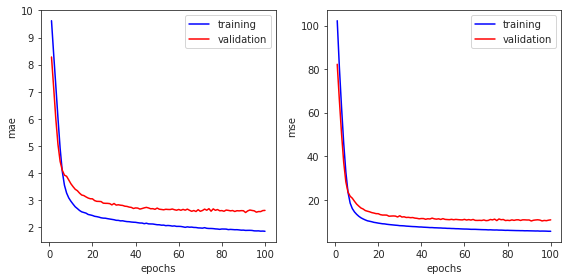

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))    

results = model_history.history

epochs = range(1,len(results['mae'])+1)

mae_values = results['mae']
val_mae_values = results['val_mae']

loss_values = results['loss']
val_loss_values = results['val_loss']

    
#mae
axs[0].plot(epochs,mae_values,color='blue',label='training',linewidth=1.5,linestyle='-')
axs[0].plot(epochs,val_mae_values,color='red',label='validation',linewidth=1.5,linestyle='-')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('mae')
#axs[0].set_ylim([0,1.0])   
axs[0].legend(loc='best')
    
#loss       
axs[1].plot(epochs,loss_values,color='blue',label='training',linewidth=1.5,linestyle='-')
axs[1].plot(epochs,val_loss_values,color='red',label='validation',linewidth=1.5,linestyle='-')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('mse')
#axs[1].set_ylim([0,2])   
axs[1].legend(loc='best');

plt.tight_layout()

In [13]:
#this is the std deviation of the target variable in the test set
np.std(y_test)

2.9308892641014777

# Prospects
    1. Fight overfit (regularization/dropout)
    2. Study effects of cuts (surely my filters are not good)
    3. What to do with pop_max = 0? 
    4. Hyperparameter search of the NN (very interesting!)
    5. K-fold cross validation